In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing
from matplotlib import pyplot as plt
from warnings import filterwarnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.graphics.tsaplots as sgt
import pmdarima as pm
import numpy as np
from arch import arch_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [2]:
filterwarnings("ignore")


In [3]:
df = pd.read_csv("ghana_gdp.zip", parse_dates=['year'], index_col=['year'])

In [4]:
df

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


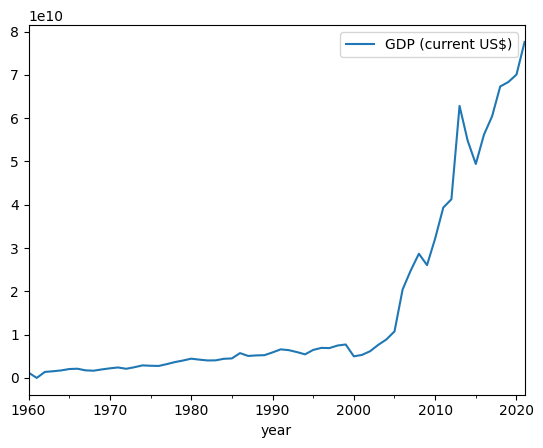

In [5]:
%matplotlib inline


df.plot()
plt.show()

In [6]:
train_df = df.loc[:"2018-01-01"]
test_df = df.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 1), (3, 1))

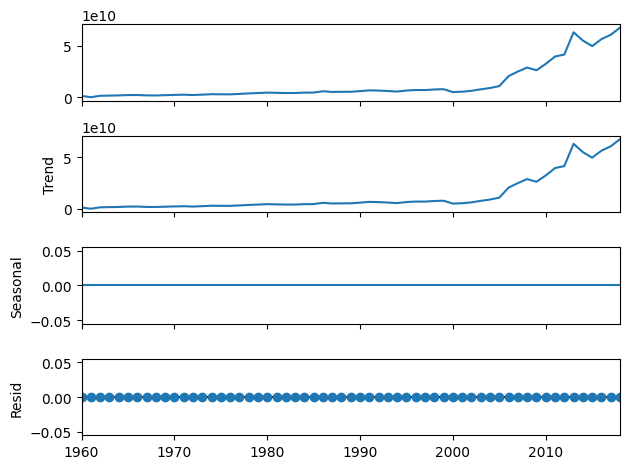

In [7]:
decomposition = seasonal_decompose(train_df, model='additive') 
decomposition.plot()
plt.show()

По данным графикам можно сделать вывод:
* Постоянное увеличение значений временного ряда со временем. Тренд с постепенным увелечением. После 2010 года резкий скачек, затем  резкое падение, но рост по всему рассматриваемого периода вообщем продолжается. 
* Данные не содержат явных сезонных колебаний. Отсутствие смещения сезонности позволяет считать сезонную компоненту сбалансированной и центрированной вокруг нулевой базовой линии

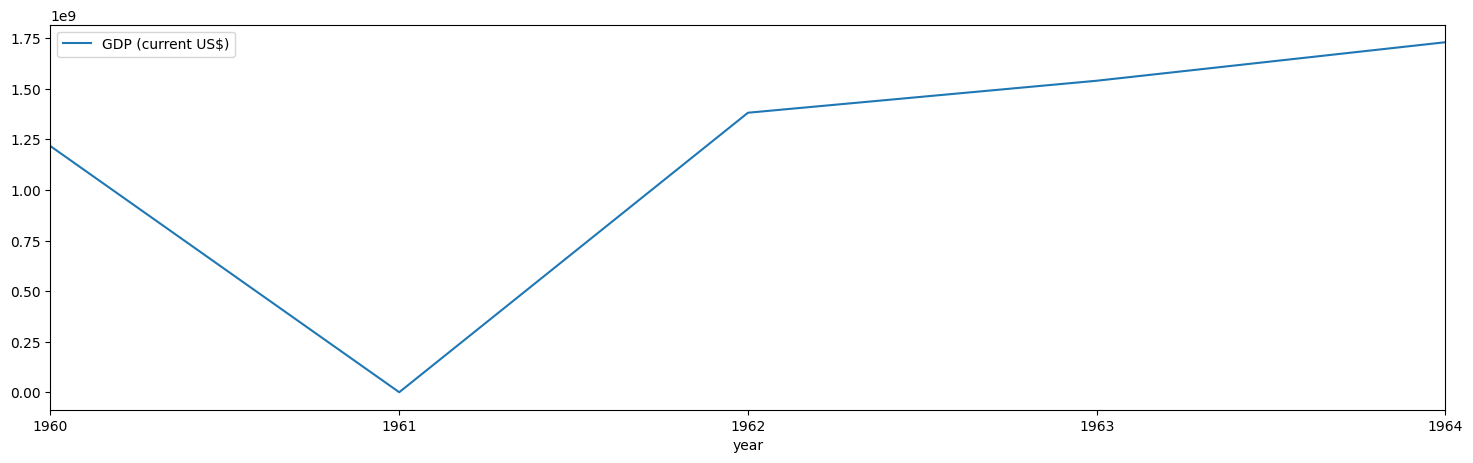

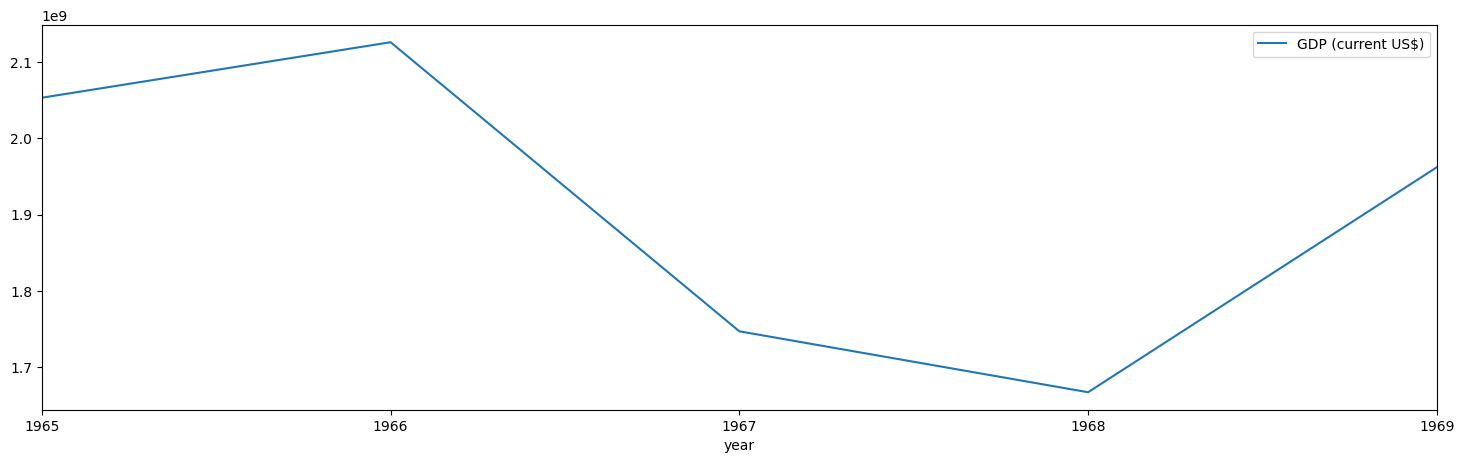

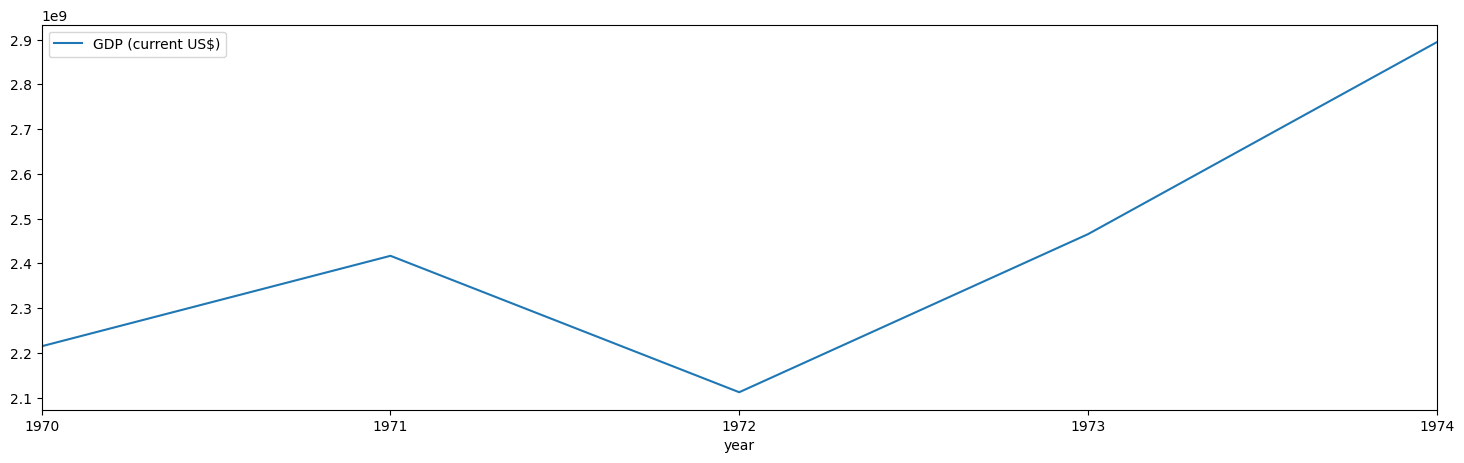

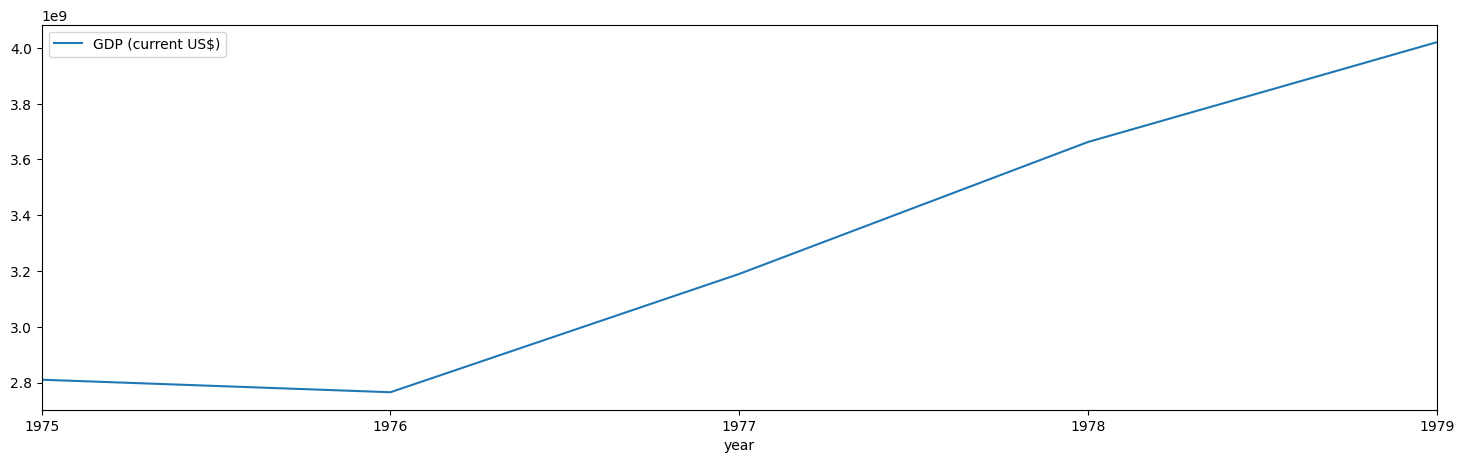

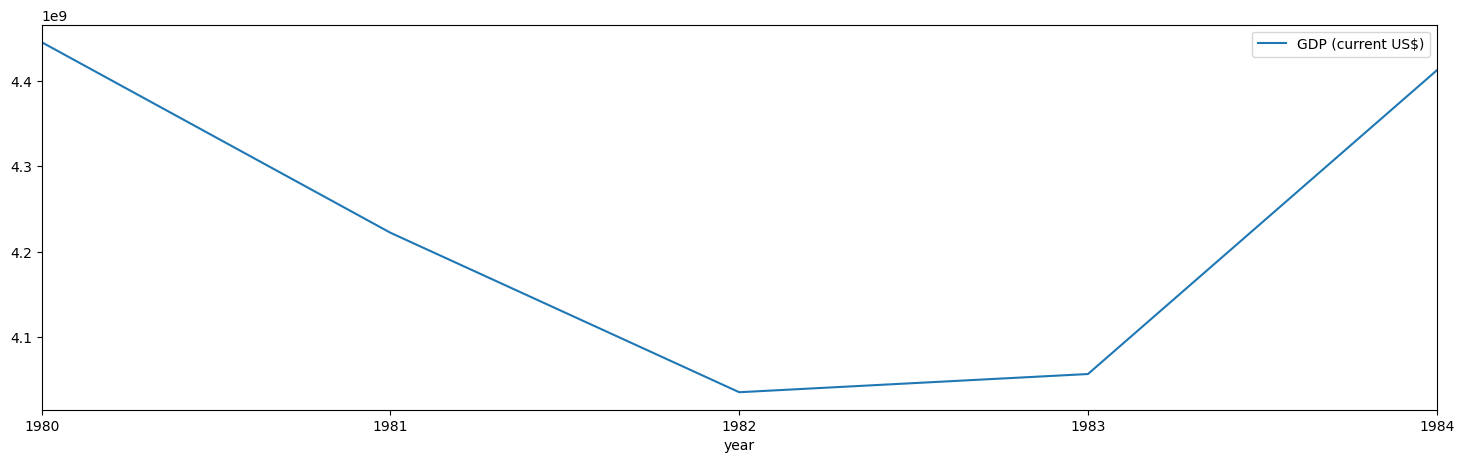

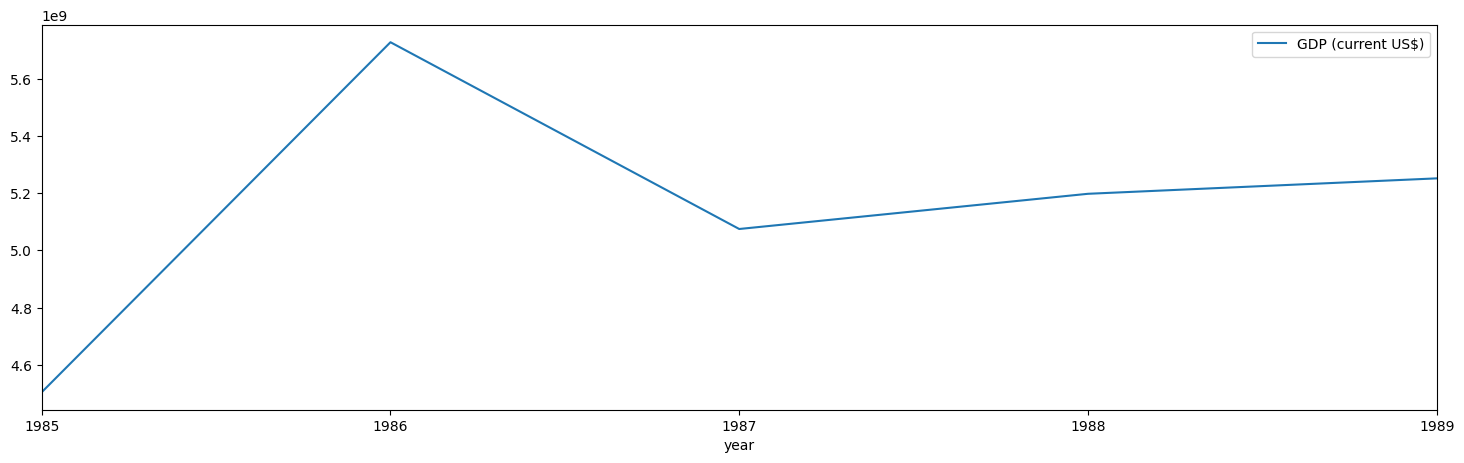

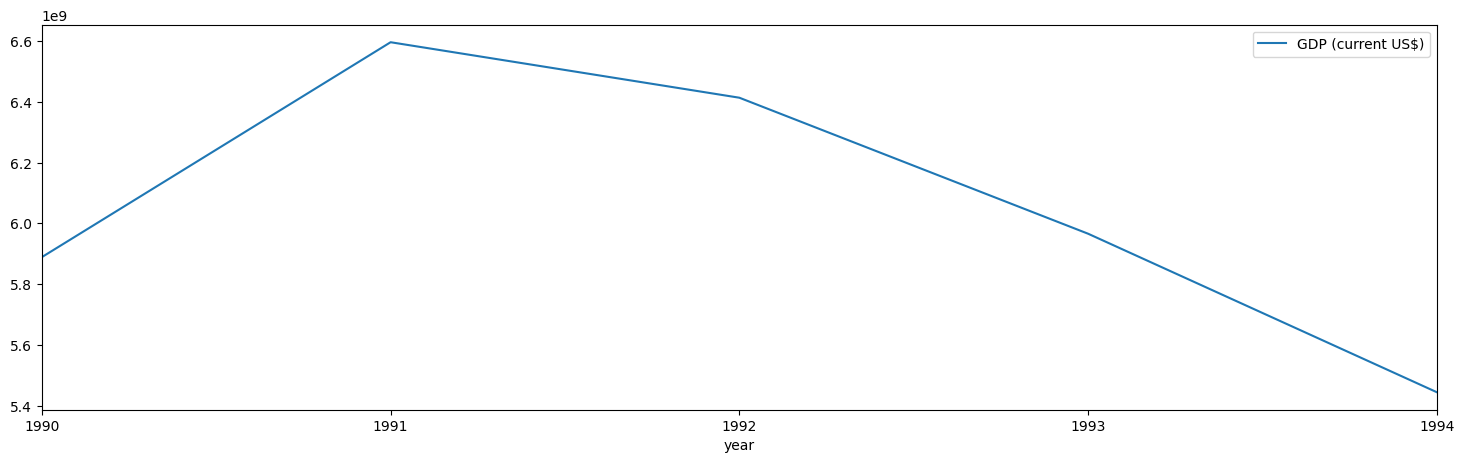

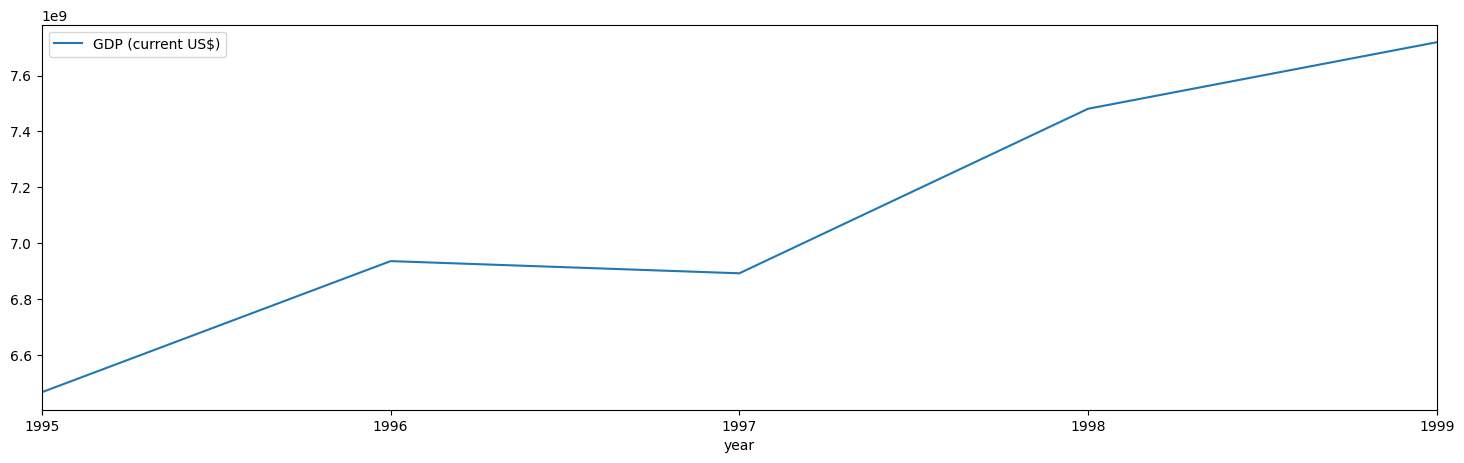

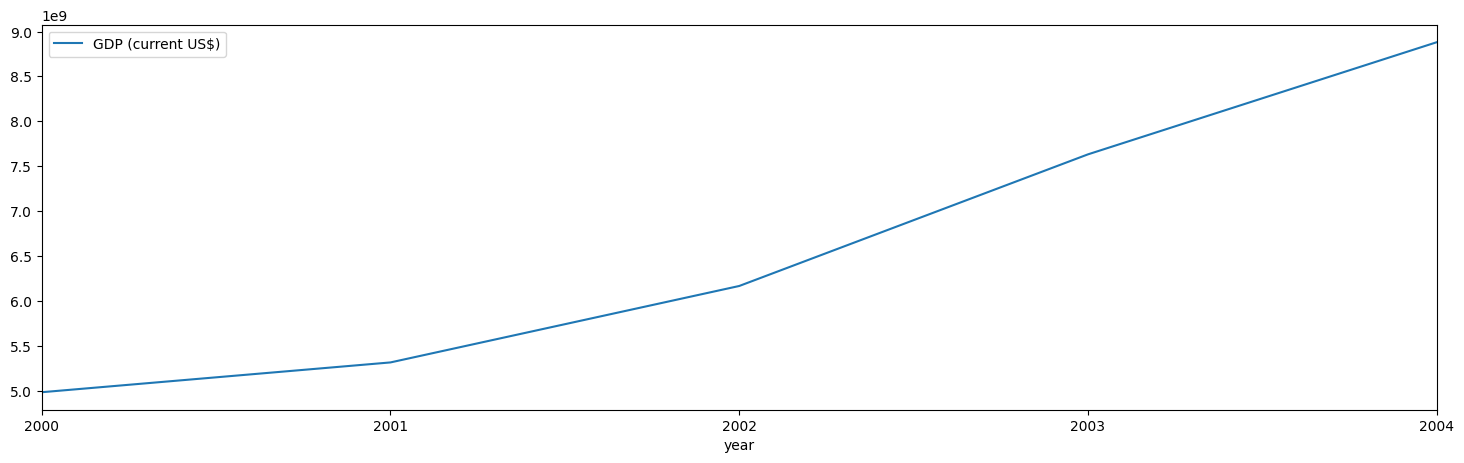

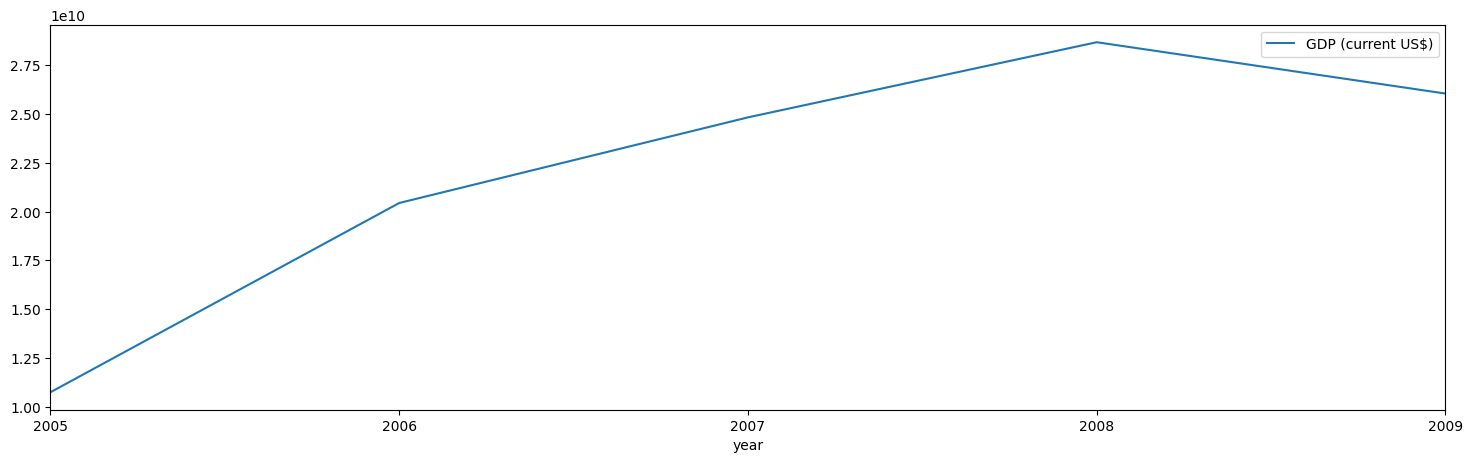

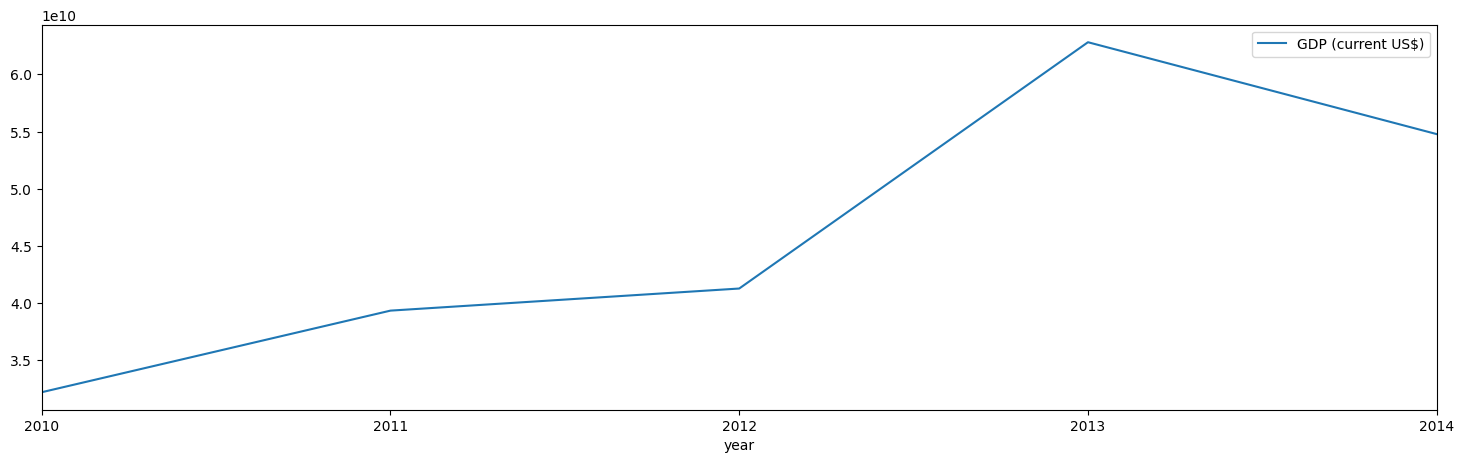

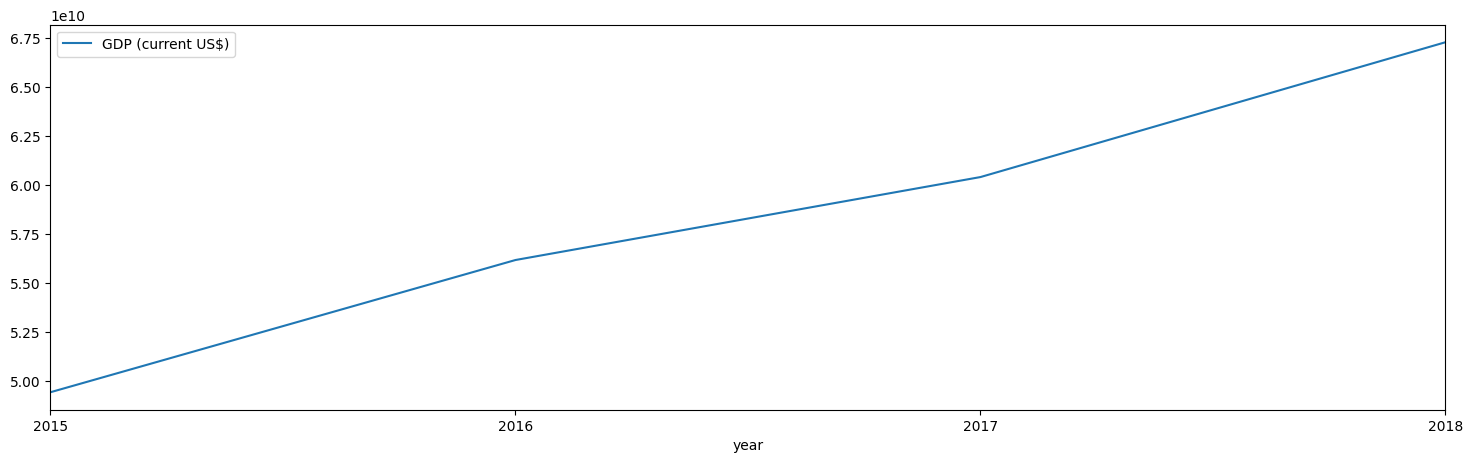

In [10]:
plt.rcParams["figure.figsize"] = 18, 5
for i in range (0,60,5):
    train_df.loc[train_df.index[i:i+5]].plot()
    plt.show()

Разбив весь период на пятилетние отрезки, то графики показывают не на всех временных отрезках  явный тренд. Для более явного прослеживания тренда нам поможет график  скользящего среднего 

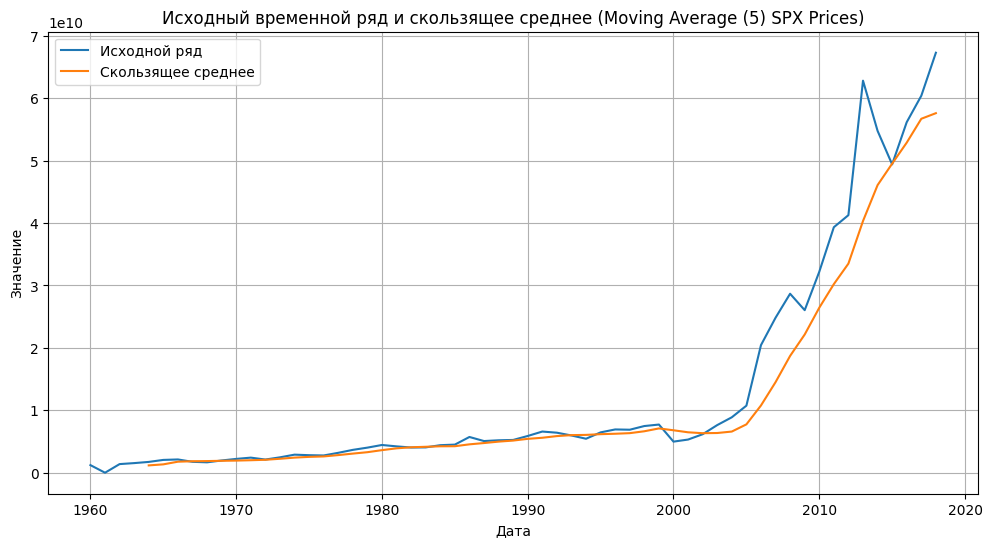

In [11]:
# Размер окна для скользящего среднего
window_size = 5

# Вычисление скользящего среднего
train_df['MA'] = train_df['GDP (current US$)'].rolling(window=window_size).mean()

# Визуализация исходного временного ряда и скользящего среднего
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df['GDP (current US$)'], label='Исходной ряд')
plt.plot(train_df.index, train_df['MA'], label='Скользящее среднее')
plt.title('Исходный временной ряд и скользящее среднее (Moving Average (5) SPX Prices)')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()


По графику скользящего среднего видно:
* с начало наблюдения до 2005 года идет плавный рост ряда
* после 2005 резкий скачек, рост продолжается 

In [12]:
train_df = train_df.drop('MA', axis=1)


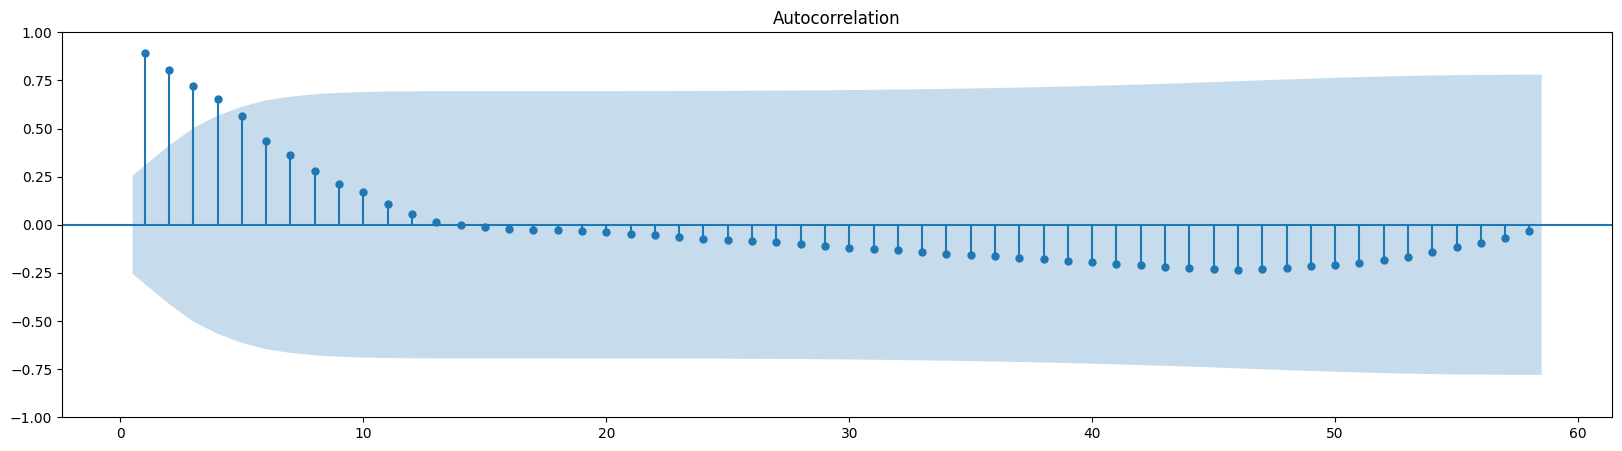

In [13]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_df['GDP (current US$)'], lags=58, zero=False)
plt.show()

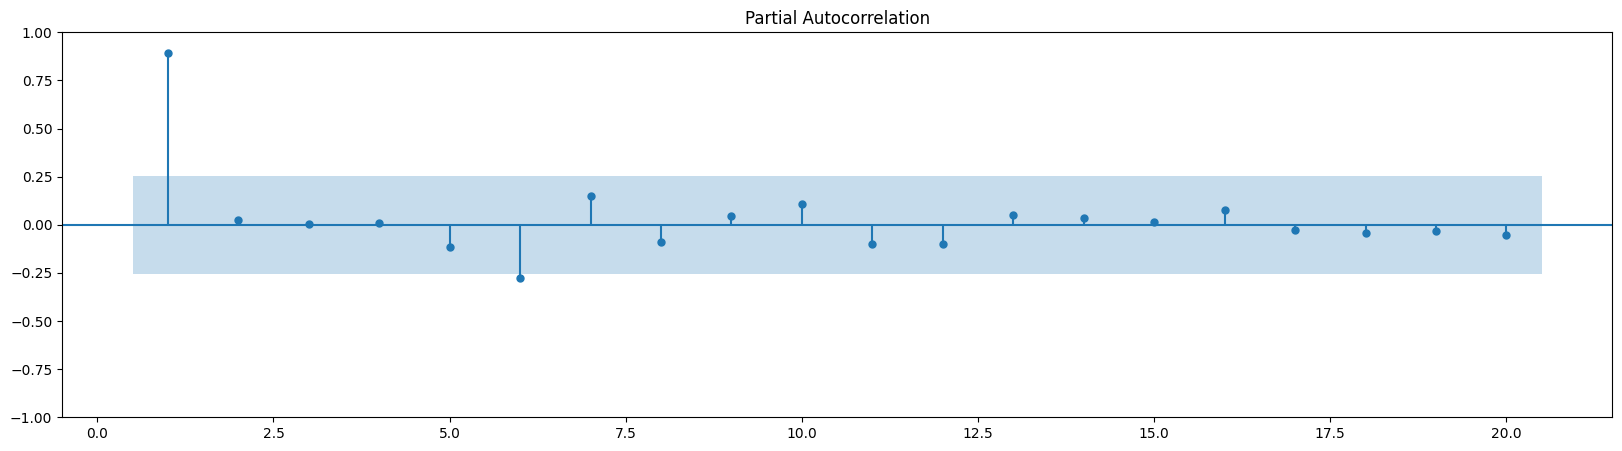

In [14]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df['GDP (current US$)'], lags=20, method="ywm", zero=False)
plt.show()

In [15]:
test1 = adfuller(train_df['GDP (current US$)'])
print("adf: ", test1[0])
print("p-value: ", test1[1])
print("Critical values: ", test1[4])
if test1[0] > test1[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  0.6529066974885367
p-value:  0.9888496277665573
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


Статистика теста больше всех критических значений, поэтому нулевую гипотезу ($H_0$) нельзя отвергнуть.

Поэтому значения GDP (current US$) не являются стационарными

## Дифференцирование ряда

In [16]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0], lags=20)
    sgt.plot_pacf(series, ax=axes[1], lags=20, method="ywm")
    plt.show()

In [17]:
d = 0
result = train_df['GDP (current US$)'].diff().dropna()

while test1[0] > test1[4]["5%"]:
    result = result.diff().dropna()
    
    test1 = adfuller(result)
   
    d += 1
print("Параметр d = ", d)   

Параметр d =  2


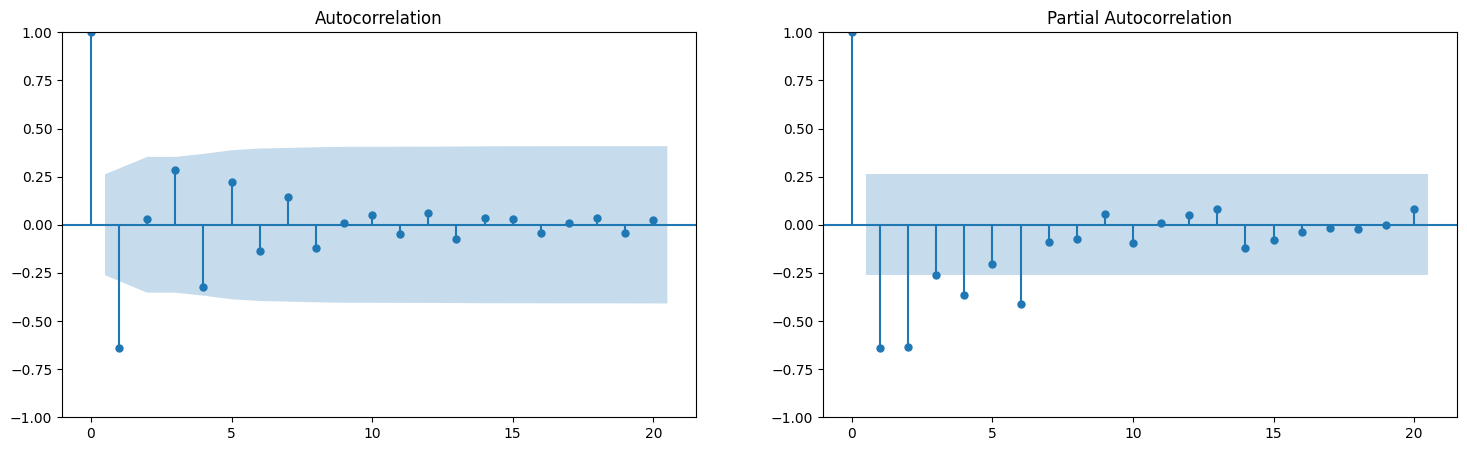

(-4.779623784828528,
 5.9483276402250296e-05,
 7,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 2060.4811556595264)

In [18]:
plot_acf_pacf(result)
adfuller(result)

Только после второго дифириинцирования ряда, разности   стали стационарными

## ARIMA

По графику ACF определяем параметр q. По графику  PACF определяем параметр p 
 * q = 1
 * p = 2

In [19]:
arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order=(2, 2, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 2, 1)   Log Likelihood               -1337.891
Date:                Wed, 13 Mar 2024   AIC                           2683.782
Time:                        20:01:49   BIC                           2691.954
Sample:                    01-01-1960   HQIC                          2686.958
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2525      0.230     -1.097      0.273      -0.704       0.199
ar.L2         -0.2149      0.291     -0.740      0.460      -0.785       0.355
ma.L1         -0.8234      0.126     -6.513      0.000      -1.071      -0.576
sigma2      1.835e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               342.07
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):             269.63   Skew:                             1.82
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.9e+55. Standard errors may be unstable.
"""

In [20]:
smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=2,
    start_q=1,
    max_p=3,
    max_q=3,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.416, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.959, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2704.667, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2683.622, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=2681.414, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=2680.988, Time=0.13 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=2680.765, Time=0.09 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=2686.992, Time=0.03 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=2682.648, Time=0.16 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=2686.657, Time=0.22 sec

Best model:  ARIMA(1,2,3)(0,0,0)[0]          
Total fit time: 0.928 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.382
Date:                Wed, 13 Mar 2024   AIC                           2680.765
Time:                        20:01:49   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.33e+55. Standard errors may be unstable.
"""

In [21]:
# Построение модели ARIMA с наилучшими параметрами
best_model = ARIMA(train_df['GDP (current US$)'], order=(1, 2, 3))
best_fit_model = best_model.fit()



In [22]:
pred_df = pd.DataFrame(index=df.index)

pred_df["model_preds"] = best_fit_model.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df["GDP (current US$)"] = df["GDP (current US$)"]

forecast = best_fit_model.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

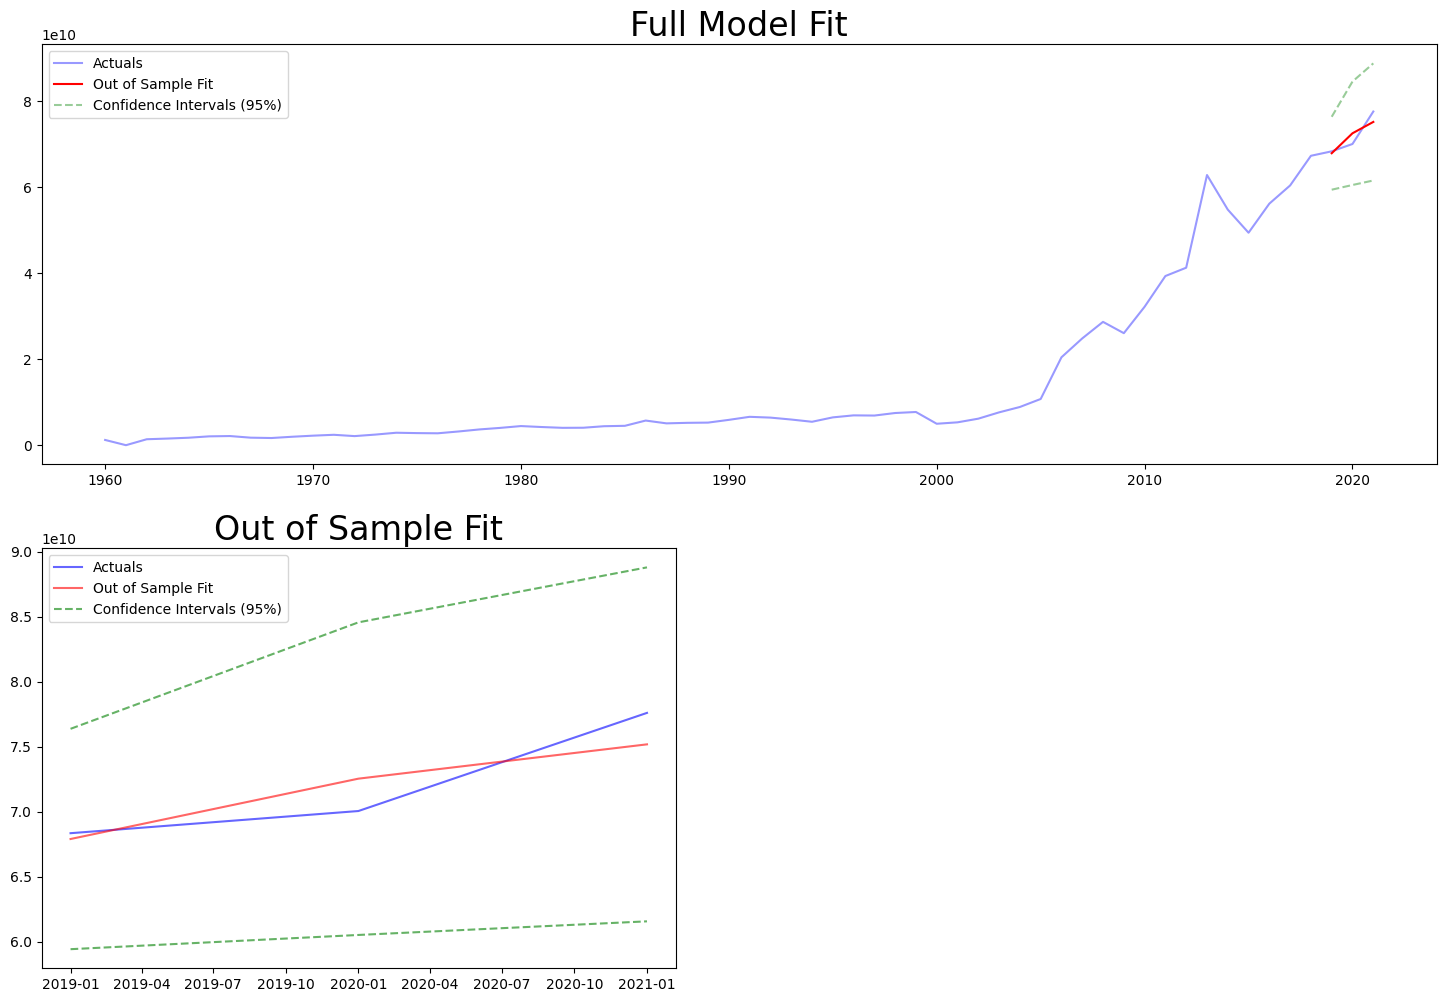

In [23]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

Модель  с наилучшими параметрами d, p, q предсказала общую тенценцию роста ряда, но еслм пресмотреться , то из трех значений, которые нужно было смоделировать:
* первое значение практически совпало с   тестовым значением
* второе больше тестового значением
* третье меньше тестового значения
Можно предположить что  модель  показывает возрастающий тренд,  но не с такой интенсивностью, как тестовые значения ряда.

## Downsampling / Upsampling (Интерполяция)

In [24]:
df.asfreq(freq='AS')

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


In [25]:
df['GDP (current US$)'].isna().sum()

0

Пропусков нет,но иногда пропуски в данных могут быть заполнены нулями. Сразу можно обратить внимание на данные за 1961-01-01

In [26]:
df['GDP (current US$)'] = df['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)

In [27]:
df['GDP (current US$)'].isna().sum()

1

После преобразования нулей выявился один пропуск

In [28]:
# Для заполнения пропусков выполните интерполяцию с использованием метода .interpolate()
df['GDP (current US$)'] = df['GDP (current US$)'].interpolate(method='linear')

In [29]:
train_df = df.loc[:"2018-01-01"]
test_df = df.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 1), (3, 1))

In [30]:
test2 = adfuller(train_df['GDP (current US$)'])
print("adf: ", test2[0])
print("p-value: ", test2[1])
print("Critical values: ", test2[4])
if test2[0] > test2[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  0.8030073326980115
p-value:  0.9916845572455877
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


In [31]:
d = 0
result = train_df['GDP (current US$)'].diff().dropna()

while test2[0] > test2[4]["5%"]:
    result = result.diff().dropna()
    
    test2 = adfuller(result)
   
    d += 1
print("Параметр d = ", d) 

Параметр d =  2


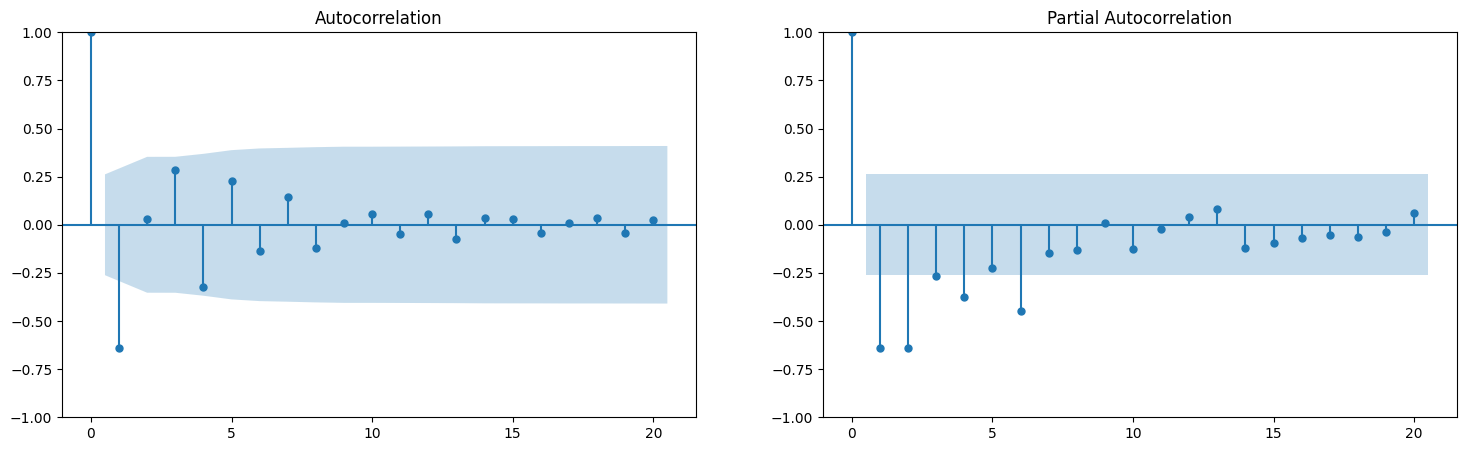

(-4.825603687304028,
 4.8573180767997966e-05,
 7,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 2060.4811556595264)

In [32]:
plot_acf_pacf(result)
adfuller(result)

In [33]:
smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=2,
    start_q=1,
    max_p=3,
    max_q=3,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.377, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.683, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2704.584, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2683.547, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=2681.389, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=2680.921, Time=0.09 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=2680.513, Time=0.09 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=2687.184, Time=0.05 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=2682.393, Time=0.13 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=2686.809, Time=0.20 sec

Best model:  ARIMA(1,2,3)(0,0,0)[0]          
Total fit time: 0.825 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.257
Date:                Wed, 13 Mar 2024   AIC                           2680.513
Time:                        20:01:52   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.4e+55. Standard errors may be unstable.
"""

In [34]:
# Построение модели ARIMA с наилучшими параметрами
best_model = ARIMA(train_df['GDP (current US$)'], order=(1, 2, 3))
best_fit_model = best_model.fit()


In [35]:
pred_df = pd.DataFrame(index=df.index)

pred_df["model_preds"] = best_fit_model.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df["GDP (current US$)"] = df["GDP (current US$)"]

forecast = best_fit_model.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

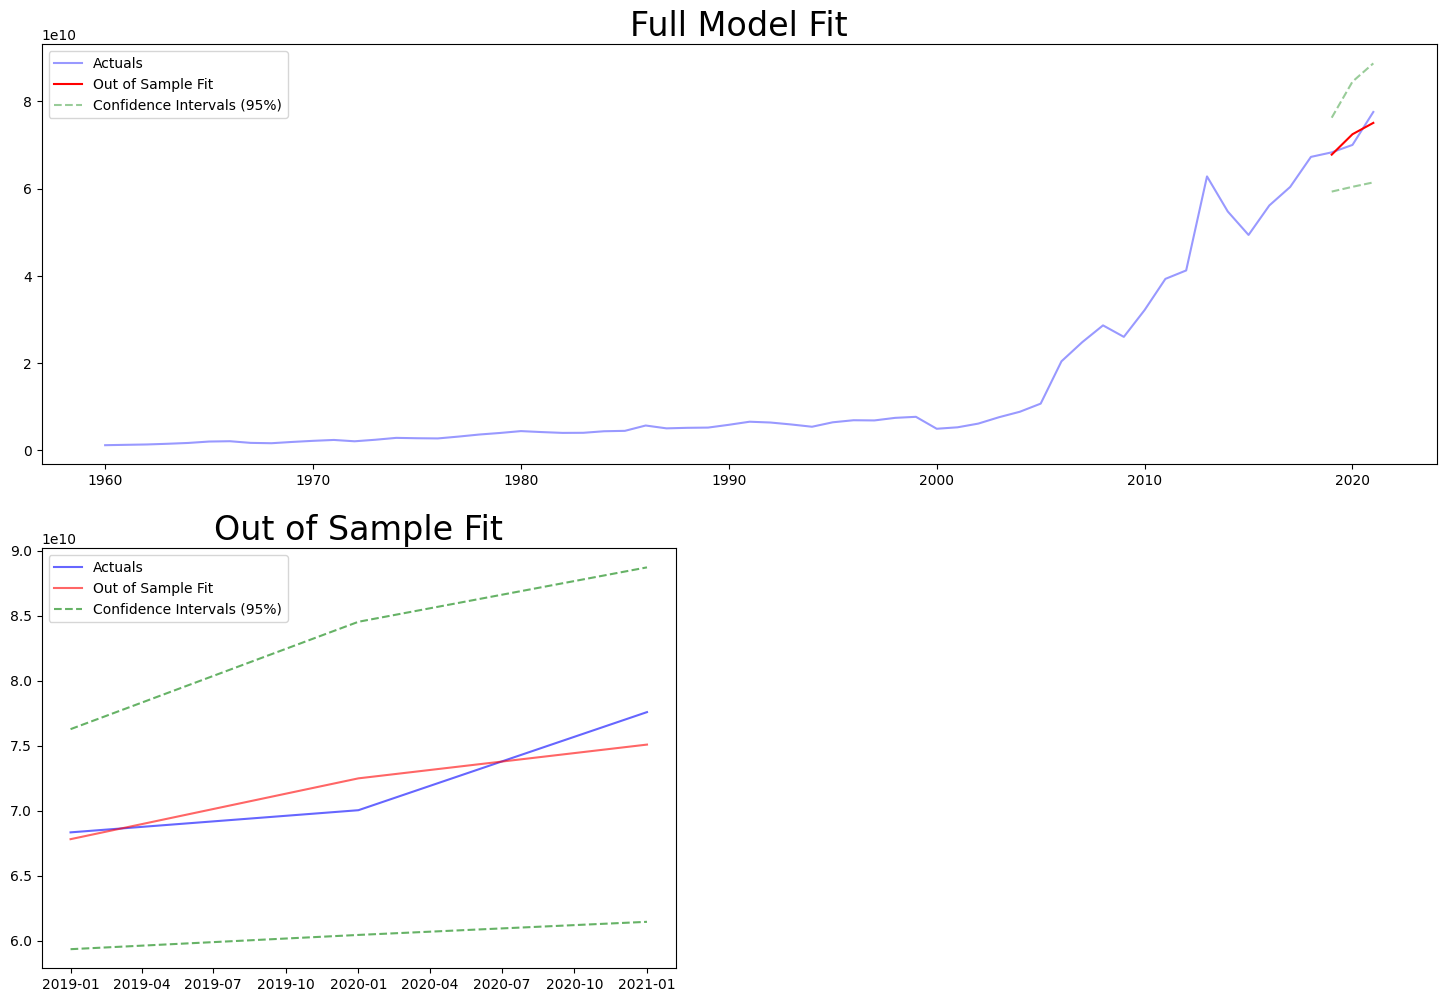

In [36]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

Модель не изменилась. Можно предположить связано с тем , что в данных был всего один пропуск.

## Волатильность 

In [37]:
df

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,1.299720e+09
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


In [38]:
df["GDP_vol"] = df['GDP (current US$)'].pct_change(1).mul(100).abs()
df["GDP_vol"]

year
1960-01-01          NaN
1961-01-01     6.789413
1962-01-01     6.357759
1963-01-01    11.448835
1964-01-01    12.363636
                ...    
2017-01-01     7.551317
2018-01-01    11.410877
2019-01-01     1.542746
2020-01-01     2.495937
2021-01-01    10.780603
Name: GDP_vol, Length: 62, dtype: float64

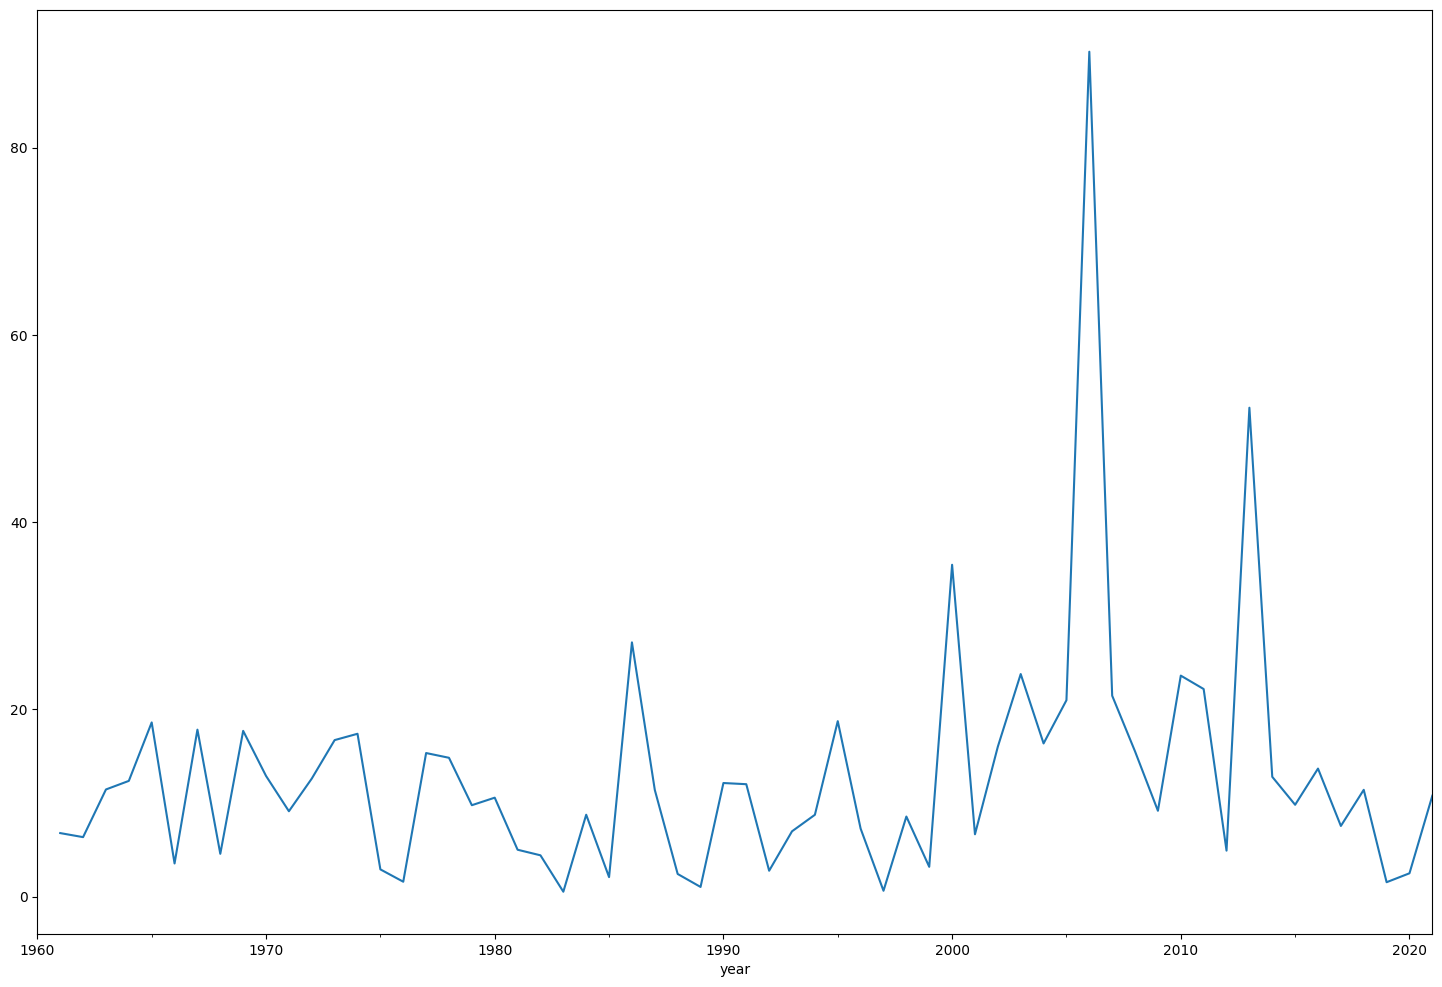

In [39]:
df['GDP_vol'].plot()
plt.show()

In [40]:
train_df = df.loc[:"2018-01-01"]
test_df = df.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 2), (3, 2))

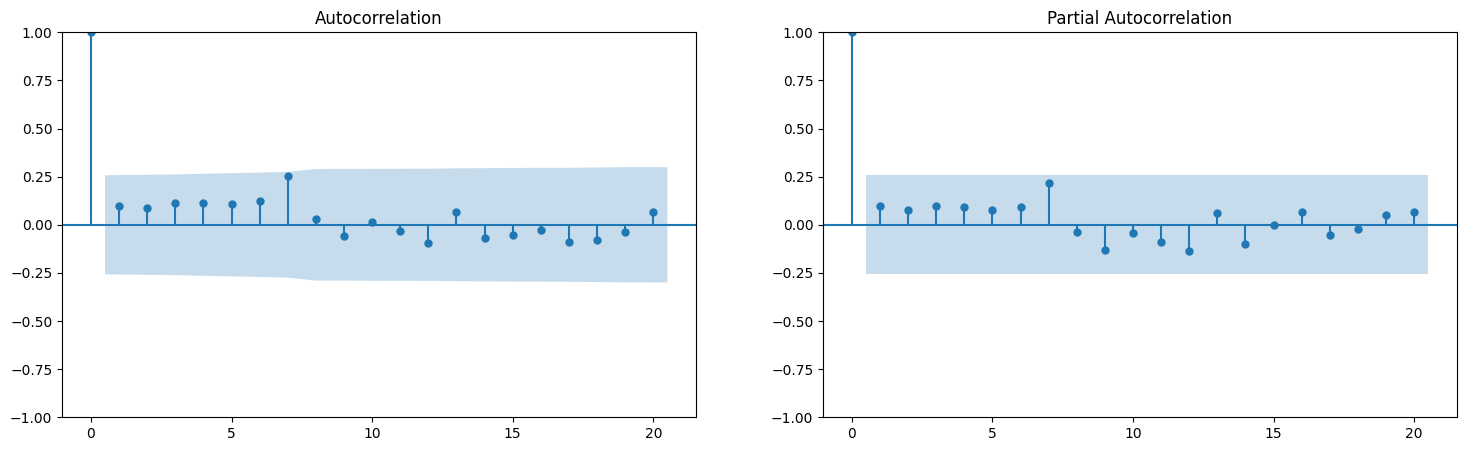

In [41]:
plot_acf_pacf(train_df['GDP_vol'][1:])

In [42]:
adfuller(train_df['GDP_vol'][1:])

(-6.725311059553779,
 3.4014596148856493e-09,
 0,
 57,
 {'1%': -3.5506699942762414,
  '5%': -2.913766394626147,
  '10%': -2.5946240473991997},
 382.739595975669)

Глядя на графики PACF и ACF для доходности и волатильности, становится ясно, что . Итак, мы построим модель GARCH с параметрами по умолчанию.

In [43]:
garch_df = pd.DataFrame(df['GDP_vol'].loc[df.index])

In [44]:
garch_df.loc[train_df.index, "GDP_vol"] = train_df["GDP_vol"].dropna()

In [45]:


model = arch_model(garch_df["GDP_vol"].dropna())

# в параметре last_obs указываем последний объект, до которого будем совершать обучение.
# в нашем случае это до первого объекта из test выборки

model_results = model.fit(last_obs=test_df.index[0], update_freq=5)

Iteration:      5,   Func. Count:     27,   Neg. LLF: 251.18811047858395
Iteration:     10,   Func. Count:     57,   Neg. LLF: 4522.5403032525255
Iteration:     15,   Func. Count:     89,   Neg. LLF: 228.00251345130135
Iteration:     20,   Func. Count:    114,   Neg. LLF: 226.5978293605918
Optimization terminated successfully    (Exit mode 0)
            Current function value: 226.59781233106128
            Iterations: 22
            Function evaluations: 123
            Gradient evaluations: 22


In [46]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                GDP_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -226.598
Distribution:                  Normal   AIC:                           461.196
Method:            Maximum Likelihood   BIC:                           469.437
                                        No. Observations:                   58
Date:                Wed, Mar 13 2024   Df Residuals:                       57
Time:                        20:01:54   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            12.3191      2.572      4.790  1.666e-06 [  7.279, 17.360]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.6700     24.738      0.148      0.882 [-44.817, 52.157]
alpha[1]   6.0947e-11  9.201e-02  6.624e-10      1.000 [ -0.180,  0.180]
beta[1]        1.0000      0.157      6.384  1.725e-10 [  0.693,  1.307]
========================================================================

Covariance estimator: robust
"""

In [47]:
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[
    test_df.index
]

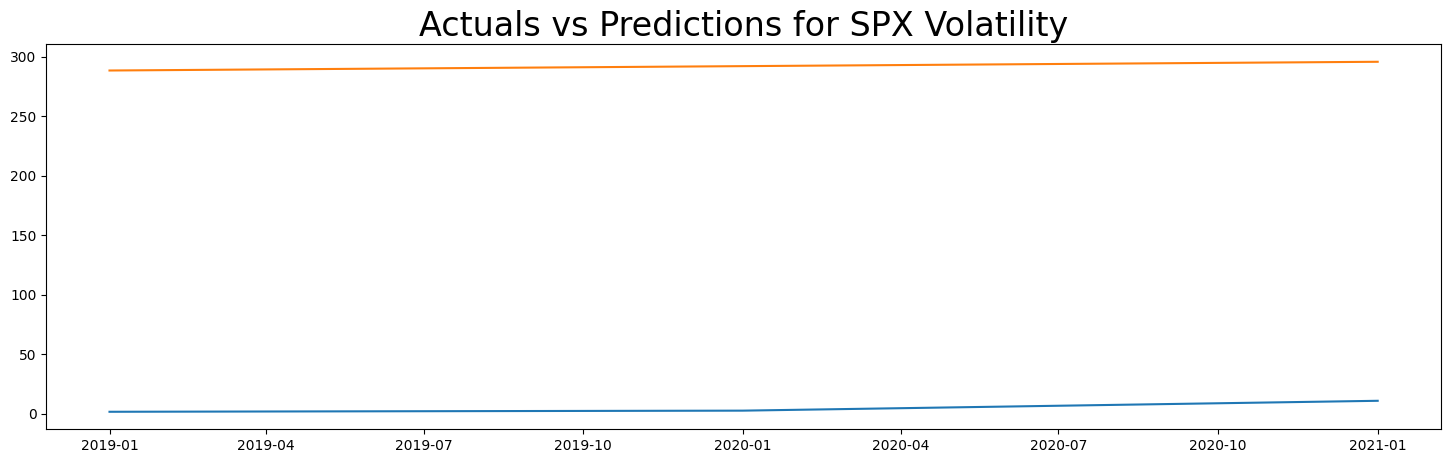

In [48]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df["GDP_vol"].abs())
plt.plot(predictions_df["Predictions"])

plt.title("Actuals vs Predictions for SPX Volatility", size=24)

plt.show()

In [49]:
mean_squared_error(
    predictions_df["GDP_vol"].abs(), predictions_df["Predictions"]
)

82531.24159419035

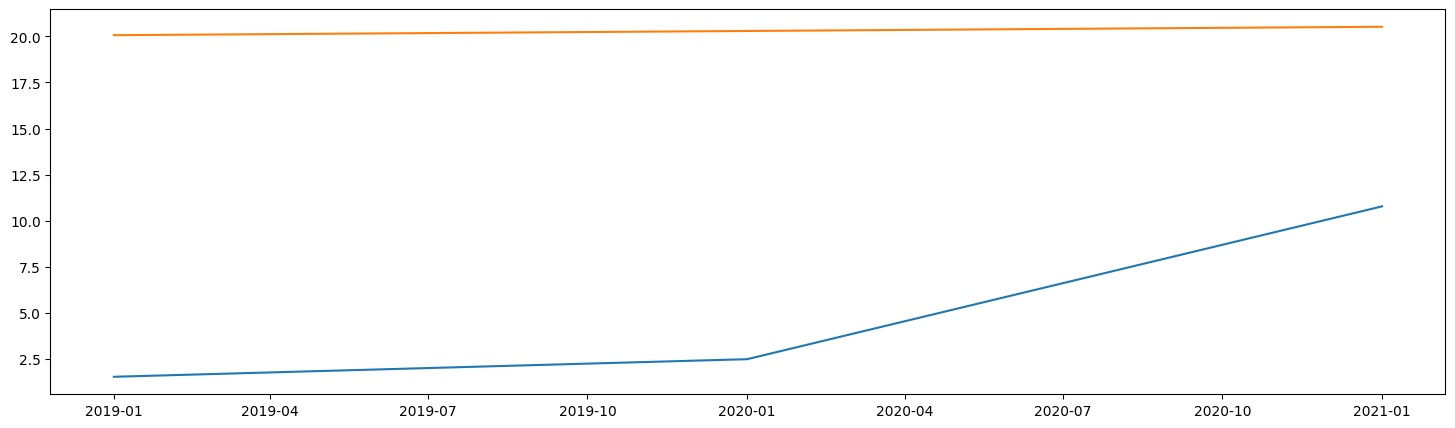

In [50]:
X_train = pd.DataFrame(range(df['GDP_vol'].shape[0]))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(df['GDP_vol'].shape[0]))[
    train_df.shape[0] :
].fillna(0)
y_train = train_df["GDP_vol"].fillna(0)
y_test = test_df["GDP_vol"].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.show()

Судя по полученному графику, модель не уловила дисперсию, так как такое поведение было для неё новым и подобные случаи отсутствовали в обучающей выборке. В примере из скринкаста был противоположный результат, так как имелось больше данных и в обучающей выборке были случаи и возрастания, и убывания дисперсии, что удалось уловить модели.